# BrainStation Capstone

Basic imports we will need

In [317]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

#spacy libraries for NLP
import spacy
from spacy.lang.en import English

#import different models to test
import time 

#import sklearn packages
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


#text processing
from sklearn.feature_extraction.text import CountVectorizer

In [318]:
#load in Loughran and McDonalds Finance Word Dict with Sentiment Value
lm_dict_df = pd.read_csv("data/LM_MasterDictionary.csv")

In [319]:
#create sentiment column with corresponding sentiments 
# I labeled all but will only focus on negative and positive
lm_dict_df['sentiment'] = None
lm_dict_df['sentiment'] = np.where(lm_dict_df['Negative'] != 0, 'negative', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Positive'] != 0, 'positive', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Uncertainty'] != 0, 'uncertainty', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Litigious'] != 0, 'litigious', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Constraining'] != 0, 'constraining', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Superfluous'] != 0, 'superfluous', lm_dict_df['sentiment'])
lm_dict_df['sentiment'] = np.where(lm_dict_df['Interesting'] != 0, 'interesting', lm_dict_df['sentiment'])

In [320]:
lm_dict_df.head()

,Word,Sequence Number,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Constraining,Superfluous,Interesting,Modal,Irr_Verb,Harvard_IV,Syllables,Source,sentiment
0,AARDVARK,1,277,1.480000e-08,1.240000e-08,3.560000e-06,84,0,0,0,0,0,0,0,0,0,0,2,12of12inf,None
1,AARDVARKS,2,3,1.600000e-10,9.730000e-12,9.860000e-09,1,0,0,0,0,0,0,0,0,0,0,2,12of12inf,None
2,ABACI,3,8,4.280000e-10,1.390000e-10,6.230000e-08,7,0,0,0,0,0,0,0,0,0,0,3,12of12inf,None
3,ABACK,4,12,6.410000e-10,3.160000e-10,9.380000e-08,12,0,0,0,0,0,0,0,0,0,0,2,12of12inf,None
4,ABACUS,5,7250,3.870000e-07,3.680000e-07,3.370000e-05,914,0,0,0,0,0,0,0,0,0,0,3,12of12inf,None


In [321]:
lm_dict_df['sentiment'].value_counts()

negative        2135
litigious        895
positive         353
uncertainty      292
constraining     184
interesting       68
superfluous       56
Name: sentiment, dtype: int64

In [322]:
#drop all columns except the word and sentiment 
lm_dict_df = lm_dict_df[['Word', 'sentiment']]

In [323]:
lm_dict_df = lm_dict_df[~lm_dict_df['sentiment'].isna()]

In [324]:
lm_dict_df.reset_index(inplace=True)

In [325]:
positive_words = list(lm_dict_df.query('sentiment == "positive"')['Word'].str.lower())
negative_words = list(lm_dict_df.query('sentiment == "negative"')['Word'].str.lower())


In [326]:
def check_word_tone(word):
    if word in positive_words:
        return 0 #f"{word} - Positive"
    if word in negative_words:
        return 1 #f"{word} - Negative"

## Data Cleaning

read in different data sets which we will start to parse and sort and build into data frames with pandas

In [327]:
#get stock symbols and company name
stock_symbol_meta = pd.read_csv('data/stock-market-dataset/symbols_valid_meta.csv')

In [328]:
#Number of Company Symbols
stock_symbol_meta.query('Symbol == "AGM$A"')

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
162,Y,AGM$A,Federal Agricultural Mortgage Corporation 5.87...,N,,N,100.0,N,NaN,AGMpA,AGM-A,N


In [329]:
stock_symbol_meta.replace('AGM$A', 'AGM-A', inplace=True)

In [330]:
stock_symbol_meta.query('Symbol == "AGM-A"')

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
162,Y,AGM-A,Federal Agricultural Mortgage Corporation 5.87...,N,,N,100.0,N,NaN,AGMpA,AGM-A,N


In [449]:
stock_symbol_meta.query('ETF == "N"')[['Symbol', 'Security Name']]

,Symbol,Security Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Corporation Common Stock
3,AACG,ATA Creativity Global - American Depositary Sh...
5,AAL,"American Airlines Group, Inc. - Common Stock"
6,AAMC,Altisource Asset Management Corp Com
...,...,...
8044,ZUO,"Zuora, Inc. Class A Common Stock"
8045,ZVO,Zovio Inc. - Common Stock
8046,ZYME,Zymeworks Inc. Common Shares
8047,ZYNE,"Zynerba Pharmaceuticals, Inc. - Common Stock"


In [467]:
#read through all stock symbols getting their stock historical data
stock_data_df_list = []
#loop through Stocks ignore ETFs for now
for i in list(stock_symbol_meta.query('ETF == "N"')['Symbol']):
    print(i, end='\r')
    path = 'data/stock-market-dataset/stocks/'+i+'.csv'
    if not os.path.exists(path):
        continue
    
    stock_data_df = pd.read_csv(path)
    stock_data_df['Symbol'] = i
    stock_data_df['Name'] = list(stock_symbol_meta[stock_symbol_meta['Symbol'] == str(i)]['Security Name'])[0]
    stock_data_df_list.append(stock_data_df)

In [469]:
#concate stock data df list
final_stock_data_df = pd.concat(stock_data_df_list)

In [470]:
final_stock_data_df.reset_index(inplace=True, drop=True)

In [475]:
final_stock_data_df[final_stock_data_df.Name.str.contains('Alphabet')]

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Name
9527604,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300.0,GOOG,Alphabet Inc. - Class C Capital Stock
9527605,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800.0,GOOG,Alphabet Inc. - Class C Capital Stock
9527606,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800.0,GOOG,Alphabet Inc. - Class C Capital Stock
9527607,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700.0,GOOG,Alphabet Inc. - Class C Capital Stock
9527608,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100.0,GOOG,Alphabet Inc. - Class C Capital Stock
...,...,...,...,...,...,...,...,...,...
9535463,2020-03-26,1114.719971,1171.479980,1092.030029,1162.920044,1162.920044,3828100.0,GOOGL,Alphabet Inc. - Class A Common Stock
9535464,2020-03-27,1127.469971,1151.050049,1104.000000,1110.260010,1110.260010,3139700.0,GOOGL,Alphabet Inc. - Class A Common Stock
9535465,2020-03-30,1132.640015,1151.000000,1098.489990,1146.310059,1146.310059,2936800.0,GOOGL,Alphabet Inc. - Class A Common Stock
9535466,2020-03-31,1148.729980,1173.400024,1136.719971,1161.949951,1161.949951,3261400.0,GOOGL,Alphabet Inc. - Class A Common Stock


In [518]:
#read json files in from folder to process into data frame
json_news_path = 'data/news/2018_05'
json_news_files = [f for f in listdir(json_news_path) if isfile(join(json_news_path, f))]

In [519]:
#start with 1000 files just to see how it runs
news_data = []
columns = ['title', 'published']

for i in range(0, len(json_news_files)):
    data = json.load(open(json_news_path+'/'+json_news_files[i]))
    print(f"Opening File {i}/{len(json_news_files)} - {json_news_files[i]}", end='\r')
    data_normalize = pd.json_normalize(data)
    
    news_data.append(list(data_normalize[['title', 'published']].iloc[0]))

In [520]:
# list(data_normalize[['title', 'text', 'published']].iloc[0])
# df = pd.DataFrame(data_normalize[['title', 'text', 'published']])
# df['published'] = pd.to_datetime(df['published'])

news_df = pd.DataFrame(news_data, columns=['title', 'published'])
#add one day to articles to ensure all stock changes were occurences after article 
news_df['published'] = pd.to_datetime(news_df['published']) + pd.DateOffset(days=1)

In [521]:
news_df['published'] = pd.to_datetime(pd.to_datetime(news_df['published'], utc=True).dt.strftime("%m/%d/%y"))

In [522]:
news_df.head()

,title,published
0,How ‘Solo’ star Donald Glover (aka Childish Ga...,2018-05-26
1,Russia's National Wealth Fund at $63.91 bln as...,2018-05-05
2,Swedish apartment prices fell 7 pct Feb-April ...,2018-05-17
3,Onxeo Provides Business Update and Reports Fir...,2018-05-17
4,CPT Technology Group's April Consolidated Reve...,2018-05-08


In [523]:
news_df.to_csv("~/BrainStation/news_2018_05.csv")

In [437]:
stockData2017up = final_stock_data_df[final_stock_data_df['Date'] > "2017-12-09"]

In [524]:
import requests


def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']


Microsoft Corporation


In [528]:
stock_symbol_meta['Name'] = None
            
for i in list(stock_symbol_meta['Symbol']):
    print(i, end='\r')
    stock_symbol_meta['Name'] = np.where(stock_symbol_meta['Symbol'] == i, get_symbol(i), stock_symbol_meta['Name'])

In [538]:
stock_symbol_meta['Symbol'] = stock_symbol_meta['NASDAQ Symbol']

In [564]:

temp_df1 = stock_symbol_meta[['Name', 'Symbol']]
temp_df1.columns = ['label', 'pattern']
temp_df2 = stock_symbol_meta[['Name', 'Name']]
temp_df2.columns = ['label', 'pattern']

temp_df = pd.concat([temp_df1, temp_df2])
temp_dict = temp_df.to_dict('records')

In [591]:
# stock_symbol_meta[['Symbol', 'Name']].to_dict('list')


<built-in method index of str object at 0x7ffb6a331768>
<built-in method index of str object at 0x7ffa11007ce0>
<built-in method index of str object at 0x7ffa11007ca8>
<built-in method index of str object at 0x7ffa11007c70>
<built-in method index of str object at 0x7ffa11007c38>
<built-in method index of str object at 0x7ffa11007c00>
<built-in method index of str object at 0x7ffa11007bc8>
<built-in method index of str object at 0x7ffa11007b90>
<built-in method index of str object at 0x7ffa11007b58>
<built-in method index of str object at 0x7ffa11007b20>
<built-in method index of str object at 0x7ffa11007ab0>
<built-in method index of str object at 0x7ffa11007a78>
<built-in method index of str object at 0x7ffa11007a40>
<built-in method index of str object at 0x7ffa11007a08>
<built-in method index of str object at 0x7ffa110079d0>
<built-in method index of str object at 0x7ffa11007998>
<built-in method index of str object at 0x7ffa11007960>
<built-in method index of str object at 0x7ffa11

<built-in method index of str object at 0x7ffa0cc3be68>
<built-in method index of str object at 0x7ffa0cc3be30>
<built-in method index of str object at 0x7ffa0cc3bdf8>
<built-in method index of str object at 0x7ffa0cc3bdc0>
<built-in method index of str object at 0x7ffa0cc3bd88>
<built-in method index of str object at 0x7ffa0cc3bd50>
<built-in method index of str object at 0x7ffa0cc3bd18>
<built-in method index of str object at 0x7ffa0cc3bce0>
<built-in method index of str object at 0x7ffa0cc3bca8>
<built-in method index of str object at 0x7ffa0cc3bc70>
<built-in method index of str object at 0x7ffa0cc3bc38>
<built-in method index of str object at 0x7ffa0cc3bc00>
<built-in method index of str object at 0x7ffa0cc3bbc8>
<built-in method index of str object at 0x7ffa0cc3bb90>
<built-in method index of str object at 0x7ffa0cc3bb58>
<built-in method index of str object at 0x7ffa0cc3bb20>
<built-in method index of str object at 0x7ffa0cc3bae8>
<built-in method index of str object at 0x7ffa0c

<built-in method index of str object at 0x7ff7884a0110>
<built-in method index of str object at 0x7ff7884a0148>
<built-in method index of str object at 0x7ff7884a0180>
<built-in method index of str object at 0x7ff7884a01b8>
<built-in method index of str object at 0x7ff7884a01f0>
<built-in method index of str object at 0x7ff7884a0228>
<built-in method index of str object at 0x7ff7884a0260>
<built-in method index of str object at 0x7ff7884a0298>
<built-in method index of str object at 0x7ff7884a02d0>
<built-in method index of str object at 0x7ff7884a0308>
<built-in method index of str object at 0x7ff7884a0340>
<built-in method index of str object at 0x7ff7884a0378>
<built-in method index of str object at 0x7ff7884a03b0>
<built-in method index of str object at 0x7ff7884a03e8>
<built-in method index of str object at 0x7ff7884a0420>
<built-in method index of str object at 0x7ff7884a0458>
<built-in method index of str object at 0x7ff7884a0490>
<built-in method index of str object at 0x7ff788

<built-in method index of str object at 0x7ffa0e27cc38>
<built-in method index of str object at 0x7ffa0e27cc70>
<built-in method index of str object at 0x7ffa0e27cca8>
<built-in method index of str object at 0x7ffa0e27cce0>
<built-in method index of str object at 0x7ffa0e27cd18>
<built-in method index of str object at 0x7ffa0e27cd50>
<built-in method index of str object at 0x7ffa0e27cd88>
<built-in method index of str object at 0x7ffa0e27cdc0>
<built-in method index of str object at 0x7ffa0e27cdf8>
<built-in method index of str object at 0x7ffa0e27ce30>
<built-in method index of str object at 0x7ffa0e27ce68>
<built-in method index of str object at 0x7ffa0e27cea0>
<built-in method index of str object at 0x7ffa0e27ced8>
<built-in method index of str object at 0x7ffa0e27cf10>
<built-in method index of str object at 0x7ffa0e27cf48>
<built-in method index of str object at 0x7ffa0e27cf80>
<built-in method index of str object at 0x7ffa0e27cfb8>
<built-in method index of str object at 0x7ffa0e

<built-in method index of str object at 0x7ff787e96848>
<built-in method index of str object at 0x7ff787e96810>
<built-in method index of str object at 0x7ff787e967d8>
<built-in method index of str object at 0x7ff787e967a0>
<built-in method index of str object at 0x7ff787e96768>
<built-in method index of str object at 0x7ff787e96730>
<built-in method index of str object at 0x7ff787e966f8>
<built-in method index of str object at 0x7ff787e966c0>
<built-in method index of str object at 0x7ff787e96688>
<built-in method index of str object at 0x7ff787e96650>
<built-in method index of str object at 0x7ff787e96618>
<built-in method index of str object at 0x7ffb6a0875a8>
<built-in method index of str object at 0x7ff787e965e0>
<built-in method index of str object at 0x7ff787e965a8>
<built-in method index of str object at 0x7ff787e96570>
<built-in method index of str object at 0x7ff787e96538>
<built-in method index of str object at 0x7ff787e96500>
<built-in method index of str object at 0x7ff787

In [539]:
stock_symbol_meta.to_csv("~/BrainStation/stock_symbol_meta.csv")

In [400]:
import string

In [426]:
news_df['title'] = news_df['title'].str.strip().str.replace('-', ' ').str.lower().str.replace('[{}]'.format(string.punctuation), '')

In [438]:
news_df.sort_values(by='published', inplace=True)
news_df.reset_index(drop=True, inplace=True)

In [439]:
news_df['title'][0]

"Golden Globes Predictions for Netflix's The Crown, Mudbound | Fortune"

In [369]:
#check word in title test
sentences = list(news_df['title'])
sentiment_dict = {'sentiment':[], 'headline': []}

for i in range(len(sentences)):
    word_list = sentences[i].split()
    positive_count = 0
    negative_count = 0
    for word in word_list:
        result = check_word_tone(word)
        if result == 0:
            positive_count += 1
        elif result == 1:
            negative_count += 1
    if positive_count > negative_count:
        sentiment_dict['headline'].append(sentences[i])
        sentiment_dict['sentiment'].append('positive')
#         print(f"Positive - Positive Words: {positive_count} | Negative Words: {negative_count} \n{sentences[i]}")
    elif positive_count < negative_count:
        sentiment_dict['headline'].append(sentences[i])
        sentiment_dict['sentiment'].append('negative')
#         print(f"Negative - Positive Words: {positive_count} | Negative Words: {negative_count} \n{sentences[i]}")
    else:
        sentiment_dict['headline'].append(sentences[i])
        sentiment_dict['sentiment'].append('neutral')

In [269]:
new_sentiment_df = pd.DataFrame(sentiment_dict)

In [270]:
new_sentiment_df.head()

,sentiment,headline
0,neutral,emerging markets mexican peso seesaws over dol...
1,neutral,migrants must visit nazi concentration camps g...
2,neutral,euro zone businesses start 2018 on decade high
3,neutral,russias lavrov says unilateral actions by us i...
4,neutral,lawmakers to justice department keep online ga...


In [271]:
#convert sentiment to numerical values
# positive -> 0
# negative -> 1
# neutral -> 2

new_sentiment_df['sentiment'] = np.where(new_sentiment_df['sentiment'] == 'positive', 0, new_sentiment_df['sentiment'])
new_sentiment_df['sentiment'] = np.where(new_sentiment_df['sentiment'] == 'negative', 1, new_sentiment_df['sentiment'])
new_sentiment_df['sentiment'] = np.where(new_sentiment_df['sentiment'] == 'neutral', 2, new_sentiment_df['sentiment'])

In [272]:
new_sentiment_df.head()

,sentiment,headline
0,2,emerging markets mexican peso seesaws over dol...
1,2,migrants must visit nazi concentration camps g...
2,2,euro zone businesses start 2018 on decade high
3,2,russias lavrov says unilateral actions by us i...
4,2,lawmakers to justice department keep online ga...


In [152]:
sentiment_train_data = pd.read_csv('data/sentiment_training_headline_data/all-data copy.csv', names=['Sentiment', 'Text'], encoding = "utf-8")

In [153]:
sentiment_train_data.columns = ['sentiment', 'headline']
sentiment_train_data.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [157]:
sentiment_train_data['sentiment'].value_counts().index

Index(['neutral', 'positive', 'negative'], dtype='object')

In [162]:
#convert sentiment to numerical values
# positive -> 0
# negative -> 1
# neutral -> 2
sentiment_train_data['sentiment'] = np.where(sentiment_train_data['sentiment'] == 'positive', 0, sentiment_train_data['sentiment'])
sentiment_train_data['sentiment'] = np.where(sentiment_train_data['sentiment'] == 'negative', 1, sentiment_train_data['sentiment'])
sentiment_train_data['sentiment'] = np.where(sentiment_train_data['sentiment'] == 'neutral', 2, sentiment_train_data['sentiment'])

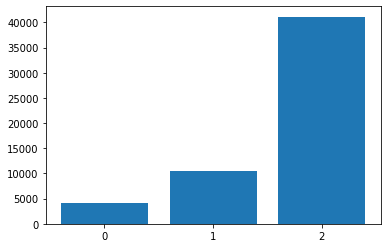

In [273]:
#see distribution of sentiment analysis 
plt.figure()
plt.bar(new_sentiment_df['sentiment'].value_counts().index, new_sentiment_df['sentiment'].value_counts())
plt.xticks(new_sentiment_df['sentiment'].value_counts().index)
plt.show()

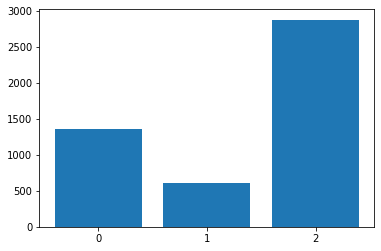

In [164]:
#see distribution of sentiment analysis
plt.figure()
plt.bar(sentiment_train_data['sentiment'].value_counts().index, sentiment_train_data['sentiment'].value_counts())
plt.xticks(sentiment_train_data['sentiment'].value_counts().index)
plt.show()

## Text Processing

### Bag of Words Count Vectorizer

In [166]:
import nltk
import string
#functin for count vectorizer tokenizer
nltk.download('stopwords')


from nltk.corpus import stopwords 

stemmer = nltk.stem.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jjackson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [167]:
#check types
sentiment_train_data = sentiment_train_data.astype({'sentiment': 'int32'})

In [168]:
sentiment_train_data.dtypes

sentiment     int32
headline     object
dtype: object

In [274]:
new_sentiment_df = new_sentiment_df.astype({'sentiment': 'int32'})

In [275]:
new_sentiment_df.dtypes

sentiment     int32
headline     object
dtype: object

In [276]:
#combine sentiment
test_sentiment_df = pd.concat([new_sentiment_df, sentiment_train_data])
test_sentiment_df

,sentiment,headline
0,2,emerging markets mexican peso seesaws over dol...
1,2,migrants must visit nazi concentration camps g...
2,2,euro zone businesses start 2018 on decade high
3,2,russias lavrov says unilateral actions by us i...
4,2,lawmakers to justice department keep online ga...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,2,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


In [277]:
#create model on newly created sentiment data to test prediciton on confirmed sentiment data
X = test_sentiment_df['headline']
y = test_sentiment_df['sentiment']

In [278]:
print(f"X shape: {X.shape} - y shape: {y.shape}")

X shape: (60559,) - y shape: (60559,)


In [279]:
#create train validation and test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [280]:
#set data for model to be trained
# X = sentiment_train_data['headline']
# y = sentiment_train_data['sentiment']

In [281]:
# print(f"X shape: {X.shape} - y shape: {y.shape}")

In [300]:
#create train validation and test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [301]:
print(f"Before Bag of Words - X_remainder shape: {X_remainder.shape} - X_test shape: {X_test.shape}")

Before Bag of Words - X_remainder shape: (48447,) - X_test shape: (12112,)


In [302]:
#we must perform text processing on the train remainder and test set
#I will use a basic count vectorizer for bag of words to start
bagofwords = CountVectorizer(tokenizer=my_tokenizer, min_df=10, ngram_range=(1,3))
bagofwords.fit(X_remainder)

# 3. Transform
X_remainder = bagofwords.transform(X_remainder)
X_test = bagofwords.transform(X_test)
print(f"After Bag of Words - X_remainder shape: {X_remainder.shape} - X_test shape: {X_test.shape}")

After Bag of Words - X_remainder shape: (48447, 8512) - X_test shape: (12112, 8512)


In [303]:
#refit the new bagofwords transformed data into dataframes
X_remainder = pd.DataFrame(X_remainder.toarray(), columns=bagofwords.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=bagofwords.get_feature_names())

In [304]:
#scale data before running tests
scaler = StandardScaler()
scaler.fit(X_remainder)
X_remainder_scaled = scaler.transform(X_remainder)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    print('The results with negation check:', end='\n\n')
    print('The # of positive words:', pos_count)
    print('The # of negative words:', neg_count)
    print('The list of found positive words:', pos_words)
    print('The list of found negative words:', neg_words)
    print('\n', end='')
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [ ]:
# as found through research recommended to check the three words ahead for negated word 
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [ ]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [ ]:
# Henry's (2008) Word List
# Henry, Elaine. “Are Investors Influenced By How Earnings Press Releases Are Written.” The Journal of Business
# Communication (1973) 45, no. 4 (2008): 363–407.
hdict = {'Negative': ['negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                      'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                      'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                      'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                      'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                      'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                      'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                      'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                      'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                      'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                      'challenges', 'challenging', 'challenged'],
         'Positive': ['positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                      'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                      'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                      'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                      'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                      'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                      'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                      'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                      'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                      'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                      'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                      'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                      'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                      'exceeding', 'beat', 'beats', 'beating']}

#### Count Vectorizer Modeling

In [305]:
#create train and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder_scaled, y_remainder, test_size=0.3, random_state=1)

In [306]:
print(f"X_train shape: {X_train.shape} - X_validation shape: {X_validation.shape}")

X_train shape: (33912, 8512) - X_validation shape: (14535, 8512)


In [308]:
#train and run on validation set to hypertune
sentiment_logit = LogisticRegression(max_iter=1000)
sentiment_logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [309]:
sentiment_logit.score(X_train,y_train)

0.9999115357395613

In [310]:
sentiment_logit.score(X_validation,y_validation)

0.8818025455796353

In [252]:
#we will hypertune the C value with the validation set
C_range = [.000001, .00001, .0001, .001, .01,.1, 1, 10, 100]
train_scores = list()
validation_scores = list()
for index, c in enumerate(C_range):
    print(index, end='\r')
    logit_test = LogisticRegression(C=c, max_iter=1000)
    logit_test.fit(X_train, y_train)
    validation_scores.append(logit_test.score(X_validation, y_validation))
    train_scores.append(logit_test.score(X_train, y_train))

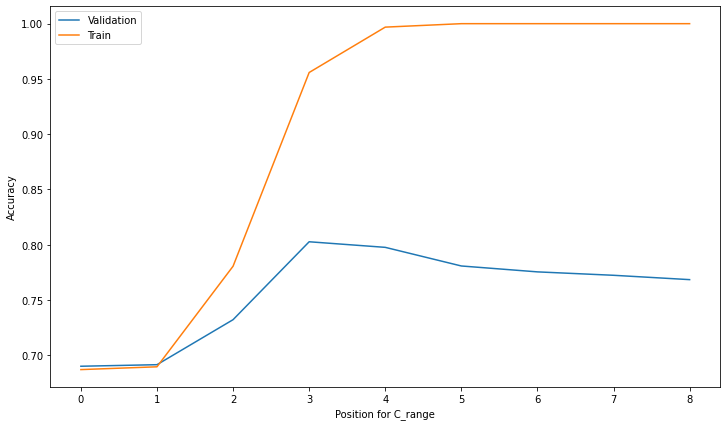

In [253]:
#Plot validation and train scores
plt.figure(figsize=(12,7))
plt.plot(range(len(C_range)), validation_scores, label="Validation")
plt.plot(range(len(C_range)), train_scores, label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Position for C_range")
plt.show()

In [ ]:
best_c = C_range[validation_scores.index(np.max(validation_scores))]
print(f"Best C is: {best_c}")

In [ ]:
sentiment_logit = LogisticRegression(C=best_c, max_iter = 1000)

In [594]:
sentiment_logit.fit(X_remainder_scaled, y_remainder)
sentiment_logit.score(X_test_scaled, y_test)

0.8832562747688243

In [256]:
#now test model on our known data set
X_known = sentiment_train_data['headline']
y_known = sentiment_train_data['sentiment']

In [257]:
# Transform
X_known = bagofwords.transform(X_known)
print(f"After Bag of Words - X_known shape: {X_known.shape}")

After Bag of Words - X_known shape: (4846, 5269)


In [258]:
X_known = pd.DataFrame(X_known.toarray(), columns=bagofwords.get_feature_names())
#scale data before running tests
scaler = StandardScaler()
scaler.fit(X_known)
X_known_scaled = scaler.transform(X_known)

In [593]:
sentiment_logit.score(X_known_scaled, y_known)

ValueError: X has 5269 features per sample; expecting 8512

### Spacy Text Processing

In [139]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_lg
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [244]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = en_core_web_lg.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [245]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [313]:
#set data for model to be trained
X = sentiment_train_data['Text'].iloc[np.where(sentiment_train_data['Sentiment'] != 2)]
y = sentiment_train_data['Sentiment'].iloc[np.where(sentiment_train_data['Sentiment'] != 2)]

In [314]:
#Count Vectorizer using spacy tokenizer
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

#TF-IDF Vectorizer with spacy tokenizer
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [315]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [316]:
#with sklearn create logisitic regression with pipeline for spacy
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('model', classifier)])



In [317]:
# model generation
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7fd5ea796080>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7fd6c3516c80>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', LogisticRegression(max_iter=1000))])

In [318]:
y_predicted = pipe.predict(X_train)

print("Spacy Classification Report: \n",classification_report(y_predicted, y_train))

Spacy Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       956
           1       1.00      1.00      1.00       420

    accuracy                           1.00      1376
   macro avg       1.00      1.00      1.00      1376
weighted avg       1.00      1.00      1.00      1376



In [319]:
y_predicted = pipe.predict(X_test)

print("Spacy Classification Report: \n",classification_report(y_predicted, y_test))

Spacy Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.80      0.86       469
           1       0.49      0.74      0.59       122

    accuracy                           0.79       591
   macro avg       0.71      0.77      0.72       591
weighted avg       0.83      0.79      0.80       591



In [326]:
title_predict = pipe.predict(news_df['title'])

In [499]:
#load english tokenizer
# importing the model en_core_web_sm of English for vocabluary, syntax & entities
import en_core_web_lg

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_lg.load()

# nlp = English()
#load stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS


docs = nlp("Trump hits Amazon with another internet tax threat")

# for word in docs:
#     print(word.text,word.pos_)
    
print(docs)
    
entities=[(i, i.label_, i.label) for i in docs.ents]
entities

Trump hits Amazon with another internet tax threat


[(Trump, 'ORG', 383), (Amazon, 'ORG', 383)]

In [500]:
from spacy import displacy

displacy.render(docs, style = "ent",jupyter = True)

In [592]:
docs = nlp("'ERI Names Anna Marie Francello Senior Director of Strategy & Business Development'")

# for word in docs:
#     print(word.text,word.pos_)
    
print(docs)
    
entities=[(i, i.label_, i.label) for i in docs.ents]
entities

'ERI Names Anna Marie Francello Senior Director of Strategy & Business Development'


[(ERI, 'ORG', 383),
 (Anna Marie Francello, 'PERSON', 380),
 (Strategy & Business Development', 'ORG', 383)]

In [502]:
from spacy import displacy

displacy.render(docs, style = "ent",jupyter = True)

In [541]:
nlp.entity.cfg

{'beam_width': 1,
 'beam_density': 0.0,
 'beam_update_prob': 1.0,
 'cnn_maxout_pieces': 3,
 'nr_feature_tokens': 6,
 'deprecation_fixes': {'vectors_name': 'en_core_web_lg.vectors'},
 'nr_class': 74,
 'hidden_depth': 1,
 'token_vector_width': 96,
 'hidden_width': 64,
 'maxout_pieces': 2,
 'pretrained_vectors': 'en_core_web_lg.vectors',
 'bilstm_depth': 0,
 'self_attn_depth': 0,
 'conv_depth': 4,
 'conv_window': 1,
 'embed_size': 2000}

In [ ]:
#news data by tickr
for ticker in nestock_meta_dfws_df['Symbol']:
    